In [38]:
import time

# visualizatoin 
import matplotlib.pyplot as plt 

# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


# learning
from sklearn.linear_model import LogisticRegression

# Load data
If you put the data set in the same folder as this notebook, you can use the following code to load the data set. 

In [39]:
# description
description = pd.read_csv('WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('training_v2.csv')

df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [40]:
# A bit of data exploration, count the amount of data entries per potentially sensitive group.
# Check for bias.
df['ethnicity'].value_counts()


Caucasian           70684
African American     9547
Other/Unknown        4374
Hispanic             3796
Asian                1129
Native American       788
Name: ethnicity, dtype: int64

In [41]:
df['gender'].value_counts()

M    49469
F    42219
Name: gender, dtype: int64

Text(0.5, 0, 'age')

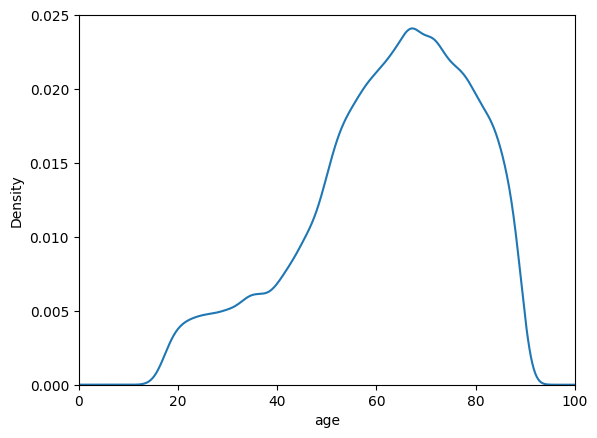

In [42]:
df['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.025)).set_xlabel('age')
# plt.savefig('age_density_plot.svg')

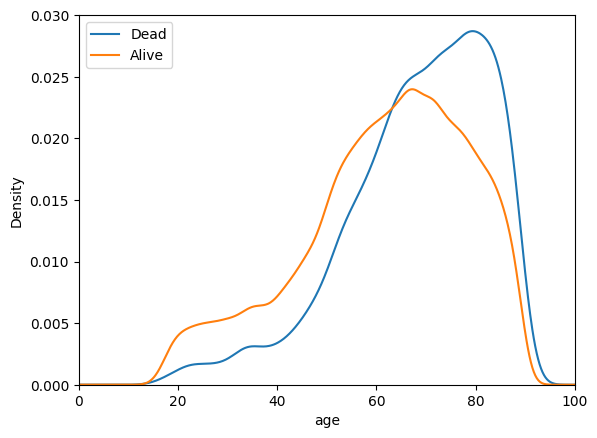

Dead: 7915
Alive: 83798
Ratio: 0.08630183289173836


In [43]:
df_death = df[df['hospital_death'] == 1]
df_alive = df[df['hospital_death'] == 0]
ax1 = df_death['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax2 = df_alive['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax1.set_xlabel('age')
ax1.legend(labels = ['Dead', 'Alive'])
plt.show()
number_dead = len(df_death['age'])
number_alive = len(df_alive['age'])
print(f'Dead: {number_dead}')
print(f'Alive: {number_alive}')
print(f"Ratio: {number_dead/(number_dead + number_alive)}")
#plt.savefig('age_death_density_plot.svg')

In [44]:
df_death['gender'].value_counts()

M    4176
F    3731
Name: gender, dtype: int64

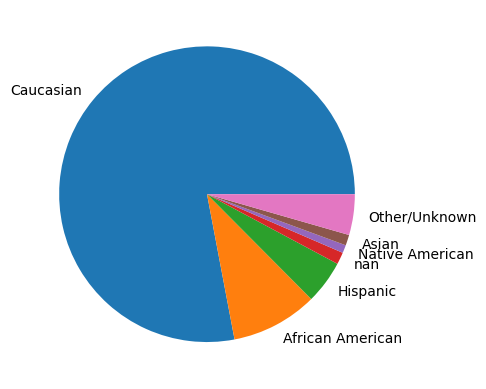

Caucasian           6168
African American     750
Hispanic             376
Other/Unknown        353
Asian                 93
Native American       70
Name: ethnicity, dtype: int64

In [45]:

ethnicity_death = {}
for key in df_death['ethnicity']:
    if key not in ethnicity_death.keys():
        ethnicity_death[key] = 0
    else:
        ethnicity_death[key] += 1 
plt.pie(ethnicity_death.values(), labels=ethnicity_death.keys())
plt.show()

df_death['ethnicity'].value_counts()


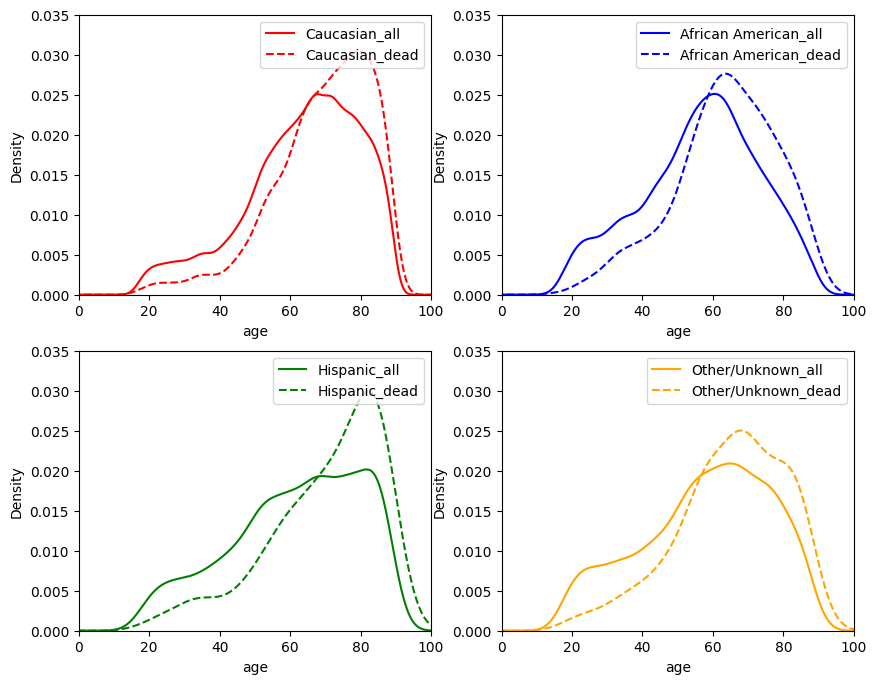

In [46]:
df_ethnicity_caucasian = df.loc[df['ethnicity'].isin(['Caucasian'])]
df_ethnicity_african_american = df.loc[df['ethnicity'].isin(['African American'])]
df_ethnicity_hispanic = df.loc[df['ethnicity'].isin(['Hispanic'])]
df_ethnicity_other_unknown = df.loc[df['ethnicity'].isin(['Other/Unknown'])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax1 = df_ethnicity_caucasian['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.025), color='red', ax=axes[0, 0]).set_xlabel('age')
ax2 = df_ethnicity_african_american['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.025), color='blue', ax=axes[0, 1]).set_xlabel('age')
ax3 = df_ethnicity_hispanic['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.025), color='green', ax=axes[1, 0]).set_xlabel('age')
ax4 = df_ethnicity_other_unknown['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.025), color='orange', ax=axes[1, 1]).set_xlabel('age')

df_death_ethnicity_caucasian = df_death.loc[df['ethnicity'].isin(['Caucasian'])]
df_death_ethnicity_african_american = df_death.loc[df['ethnicity'].isin(['African American'])]
df_death_ethnicity_hispanic = df_death.loc[df['ethnicity'].isin(['Hispanic'])]
df_death_ethnicity_other_unknown = df_death.loc[df['ethnicity'].isin(['Other/Unknown'])]

ax1_death = df_death_ethnicity_caucasian['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.035), linestyle='--', color='red', ax=axes[0, 0])
ax2_death = df_death_ethnicity_african_american['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.035), linestyle='--', color='blue', ax=axes[0, 1])
ax3_death = df_death_ethnicity_hispanic['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.035), linestyle='--', color='green', ax=axes[1, 0])
ax4_death = df_death_ethnicity_other_unknown['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.035), linestyle='--',color='orange', ax=axes[1, 1])

axes[0, 0].legend(['Caucasian_all', 'Caucasian_dead'], loc='upper right')
axes[0, 1].legend(['African American_all', 'African American_dead'], loc='upper right')
axes[1, 0].legend(['Hispanic_all', 'Hispanic_dead'], loc='upper right')
axes[1, 1].legend(['Other/Unknown_all', 'Other/Unknown_dead'], loc='upper right')

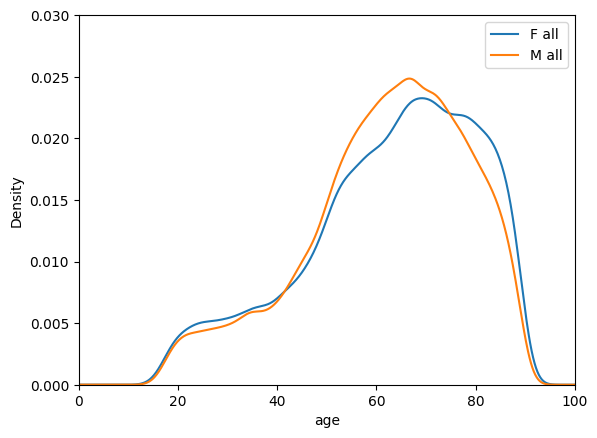

In [47]:
df_death = df[df['hospital_death'] == 1]
df_alive = df[df['hospital_death'] == 0]

df_all_gender_f = df.loc[df['gender'] == 'F']
df_alive_gender_f = df_alive.loc[df_alive['gender'] == 'F']
df_death_gender_f = df_death.loc[df_death['gender'] == 'F']

df_all_gender_m = df.loc[df['gender'] == 'M']
df_alive_gender_m = df_alive.loc[df_alive['gender'] == 'M']
df_death_gender_m = df_death.loc[df_death['gender'] == 'M']

ax1 = df_all_gender_f['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax2 = df_all_gender_m['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax1.set_xlabel('age')
ax1.legend(labels = ['F all', 'M all'])
plt.show()


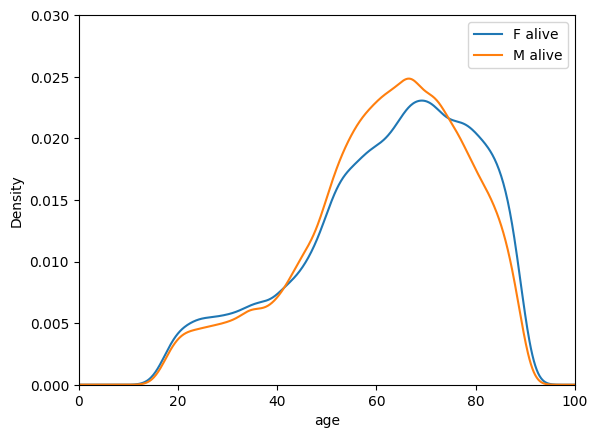

In [48]:
ax1 = df_alive_gender_f['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax2 = df_alive_gender_m['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax1.set_xlabel('age')
ax1.legend(labels = ['F alive', 'M alive'])
plt.show()

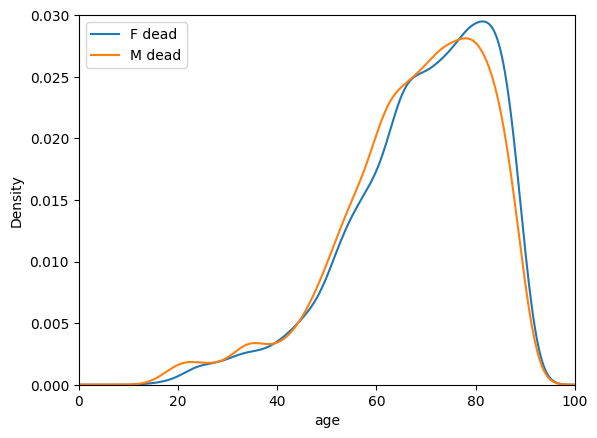

In [49]:
ax1 = df_death_gender_f['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax2 = df_death_gender_m['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax1.set_xlabel('age')
ax1.legend(labels = ['F dead', 'M dead'])
plt.show()

In [50]:
df_death['icu_type'].value_counts()

Med-Surg ICU    4426
MICU             930
Neuro ICU        638
CCU-CTICU        542
Cardiac ICU      494
SICU             390
CSICU            254
CTICU            241
Name: icu_type, dtype: int64

In [51]:
df_icu_type_Med_Surg = df.loc[df['icu_type']=='Med-Surg ICU']
df_icu_type_MICU = df.loc[df['icu_type']=='MICU']
df_icu_type_NEURO = df.loc[df['icu_type']=='Neuro ICU']
df_icu_type_CCU_CT = df.loc[df['icu_type']=='CCU-CTICU']
df_icu_type_Cardiac = df.loc[df['icu_type']=='Cardiac ICU']
df_icu_type_S = df.loc[df['icu_type']=='SICU']
df_icu_type_CS = df.loc[df['icu_type']=='CSICU']
df_icu_type_CT = df.loc[df['icu_type']=='CTICU']


values_icu_deaths = df_death['icu_type'].value_counts()
Med_Surg_death_rate = values_icu_deaths.iloc[0] / len(df_icu_type_Med_Surg)
MICU_death_rate = values_icu_deaths.iloc[1] / len(df_icu_type_MICU)
NEURO_death_rate =  values_icu_deaths.iloc[2] / len(df_icu_type_NEURO)
CCU_death_rate = values_icu_deaths.iloc[3] / len(df_icu_type_CCU_CT)
Cardiac_death_rate = values_icu_deaths.iloc[4] / len(df_icu_type_Cardiac)
S_death_rate = values_icu_deaths.iloc[5] / len(df_icu_type_S)
CS_death_rate = values_icu_deaths.iloc[6] / len(df_icu_type_CS)
CT_death_rate = values_icu_deaths.iloc[7] / len(df_icu_type_CT)

print(f"MICU death rate:              {round(MICU_death_rate, 4)} ")
print(f"Cardiac death rate:           {round(Cardiac_death_rate, 4)}")
print(f"Medical surgery death rate:   {round(Med_Surg_death_rate, 4)} ")
print(f"NEURO death rate:             {round(NEURO_death_rate, 4)}")
print(f"CCU_CT death rate:            {round(CCU_death_rate, 4)}")
print(f"S death rate:                 {round(S_death_rate, 4)}")
print(f"CT death rate:                {round(CT_death_rate, 4)}")
print(f"CS death rate:                {round(CS_death_rate, 4)}")

MICU death rate:              0.1209 
Cardiac death rate:           0.1034
Medical surgery death rate:   0.0875 
NEURO death rate:             0.0831
CCU_CT death rate:            0.0757
S death rate:                 0.0749
CT death rate:                0.0602
CS death rate:                0.0551


In [52]:
df_death['readmission_status'].value_counts()

0    7915
Name: readmission_status, dtype: int64

The dataset contains many different variables, including:

#### Target variable
* *hospital_death*: 'Whether the patient died during this hospitalization'.

#### Identifiers
* *patient_id*: Unique identifier associated with a patient
* *encounter_id*: Unique identifier associated with a patient unit stay
* *hospital_id*: Unique identifier associated with a hospital
* *icu_id*: A unique identifier for the unit to which the patient was admitted

#### Demographics
* *age*: The age of the patient on unit admission.
* *bmi*: The body mass index of the person on unit admission.
* *ethnicity*: The common national or cultural tradition which the person belongs to.
* *gender*: The genotypical sex of the patient.
* *height*: The height of the person on unit admission

#### Health indicators
A few examples:
* *elective_surgery*: Whether the patient was admitted to the hospital for an elective surgical operation
* *h1_diasbp_invasive_max*: The patient's highest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *h1_diasbp_invasive_min*: The patient's lowest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *gcs_verbal_apache*: The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score
* *immunosuppression*: Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).

In [53]:
# you can retrieve the description of a variable in the data set from the description dictionary as follows
description_dict['immunosuppression']

{'Category': 'APACHE comorbidity',
 'Unit of Measure': 'None',
 'Data Type': 'binary',
 'Description': 'Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).',
 'Example': '1'}

In [54]:
description_dict["apache_4a_hospital_death_prob"]

{'Category': 'APACHE prediction',
 'Unit of Measure': 'None',
 'Data Type': 'numeric',
 'Description': 'The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.',
 'Example': '0.31'}

In [55]:
description_dict["apache_4a_hospital_death_prob"]

{'Category': 'APACHE prediction',
 'Unit of Measure': 'None',
 'Data Type': 'numeric',
 'Description': 'The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.',
 'Example': '0.31'}

In [56]:
description_dict["apache_3j_bodysystem"]

{'Category': 'APACHE grouping',
 'Unit of Measure': 'None',
 'Data Type': 'string',
 'Description': 'Admission diagnosis group for APACHE III',
 'Example': 'Cardiovascular'}

# Pre-processing
This is a real-world data set, meaning that it is **messy**. Two key difficulties are categorial features and missing values.

> **To avoid information leakage, any pre-processing steps must be based on the training data only.** For example, when we compute the mean, this must be computed based on the training data set.

### Categorical Features
Many (implementations of) machine learning algorithms cannot handle categorical features automatically. This is often dealt with through *one-hot-encoding*, where each category of a feature is transformed into a binary feature.

When a feature contains many categories, this results in a very sparse data set with many features. As such, it can be worthwile to use domain expertise to merge particular categories in order to reduce the number of one-hot-encoded features.

### Missing Values
The data set contains a lot of missing values (around 35% of the values is missing). There are several ways to deal with this, some ideas to try:

* Replace missing values with the mean (numerical features) or median (categorical features), e.g., using [`SimpleImputer`](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation).
* Drop features with many missing values.
* Model-based imputation strategies, such as [KNNImputer](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation).
* Domain-knowledge inspired replacement. For example, for features related to medical measurements, it is expected that the entered data is abnormal in some way. As such, replacing by the mean or median can paint a skewed picture. One way to deal with this would be to identify a normal range for different measurements, based on domain expertise. *Note: this is a very time consuming strategy which we do not necessarily recommend in the time span of this project.*

We encourage you to try several approaches and see what works best.

## Example of  Minimal Pre-Processing
Below you can find an example of pre-processing the data set for classification. We showcase both 'manual' pre-processing steps through `pandas` as well as a (small) scikit-learn `Pipeline`. Feel free to use whatever you are most comfortable with in your project.

In [57]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

In [58]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("imputer", SimpleImputer(strategy="mean")),
                                  ("scaler", StandardScaler())
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"))])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])
# pipeline
prep_pipeline.fit(X_train, y_train)
# display(prep_pipeline) # display preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

Time: 2.16s
Train set: 73370 rows, 184 columns
Validation set: 9171 rows, 184 columns
Test set: 9172 rows, 184 columns


## Simple Logistic Regression Model
We can now train a simple logistic regression model.

> **Warning**. The following code will lead to a convergence warning. To solve this "issue", you can increase `max_iter` and/or apply a `sklearn.preprocessing.StandardScaler()`. However, the model still performance reasonably well even without convergence.

In [59]:
start_time = time.time()

# train logistic regression model
lr = LogisticRegression(penalty='l1', solver='saga')
lr.fit(X_train, y_train)

print("Time: %.2fs" % (time.time() - start_time))

Time: 20.56s


The max_iter was reached which means the coef_ did not converge


In [60]:
# Print most 
lr.feature_names_in_.shape
lr.coef_[0].shape
coefficients = np.column_stack((lr.feature_names_in_, lr.coef_[0]))
coefficients_sorted = coefficients[np.abs(coefficients[:, 1]).argsort()]
print(coefficients_sorted[-20:, :])

[['cat__hospital_admit_source_PACU' -0.23420225100886088]
 ['num__h1_sysbp_noninvasive_max' 0.23899641528037294]
 ['cat__icu_admit_source_Other ICU' 0.2411447501245961]
 ['cat__hospital_admit_source_nan' -0.24146933105788845]
 ['num__gcs_motor_apache' -0.2516356054182727]
 ['num__d1_creatinine_max' -0.27388354153016353]
 ['num__elective_surgery' -0.28999126205818143]
 ['num__h1_mbp_noninvasive_min' -0.29944172616958736]
 ['cat__apache_3j_bodysystem_Genitourinary' -0.3136608067220135]
 ['num__d1_bun_min' 0.3160481317359373]
 ['num__d1_heartrate_max' 0.3264769822827916]
 ['cat__icu_admit_source_Other Hospital' 0.33304628597470737]
 ['num__ventilated_apache' 0.37466632651250603]
 ['cat__apache_3j_bodysystem_Neurological' 0.40047811051653215]
 ['num__age' 0.42588524739639066]
 ['cat__apache_3j_bodysystem_nan' 0.42839716830042457]
 ['cat__hospital_admit_source_Operating Room' -0.4636559972657328]
 ['cat__icu_type_CSICU' -0.4745178382919429]
 ['cat__icu_admit_source_Operating Room / Recovery

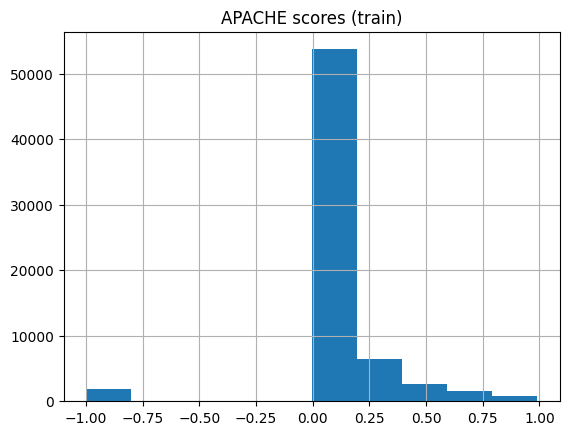

In [61]:
# histogram
y_apache_train.hist()
plt.title("APACHE scores (train)")
plt.show()

# APACHE IV Scores
APACHE ("Acute Physiology and Chronic Health Evaluation") is a scoring system assessing severity of illness and prognoses of ICU patients. The scoring system has been improved over time, with APACHE II being released in 1985, APACHE III in 1991, and finally APACHE IV in 2006. APACHE IV has been evaluated and validated in patients for mortality outcome. 

In the dataset, the *apache_4a_hospital_death_prob* column corresponds to the APACHE IV probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.
* `-1` means the score couldn't be calculated for some reason. In particular, the patient encounter could have been a re-admission. 
* `NaN` indicates a missing score, due to e.g., a missing covariate that made it impossible to compute the score. 


## Some additional histograms for exploration

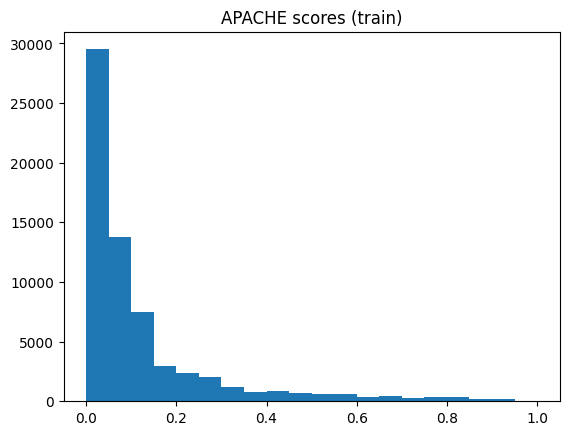

In [62]:
# histogram
plt.hist(y_apache_train, range=[0, 1], bins=20, )#log=True)
plt.title("APACHE scores (train)")
plt.show()

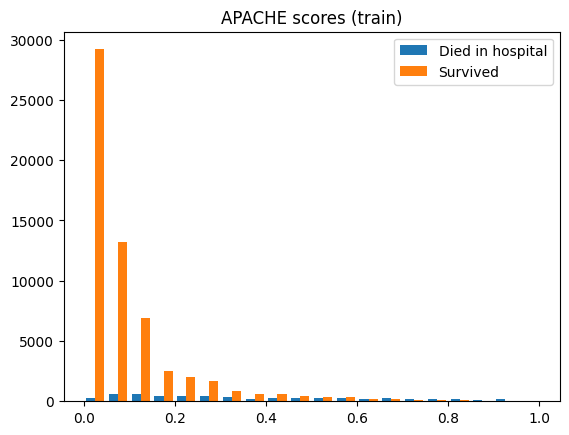

In [63]:
# histogram
data = [y_apache_train[y_train==1], y_apache_train[y_train==0]]
plt.hist(data, range=[0, 1], bins=20)
plt.legend(["Died in hospital", "Survived"])
plt.title("APACHE scores (train)")
plt.show()

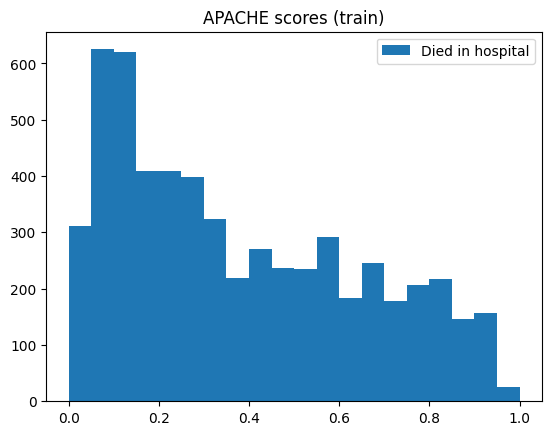

In [64]:
# histogram
plt.hist(y_apache_train[y_train==1], range=[0, 1], bins=20)
plt.legend(["Died in hospital"])
plt.title("APACHE scores (train)")
plt.show()

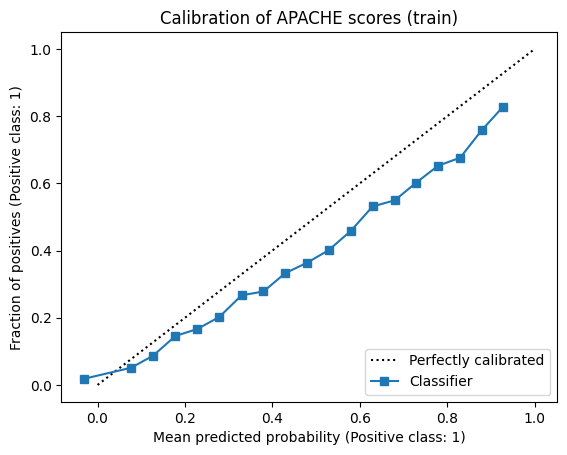

In [65]:
from sklearn.calibration import CalibrationDisplay

display = CalibrationDisplay.from_predictions(
    y_train, 
    y_apache_train, 
    n_bins=20
).plot
plt.title("Calibration of APACHE scores (train)")
plt.show()

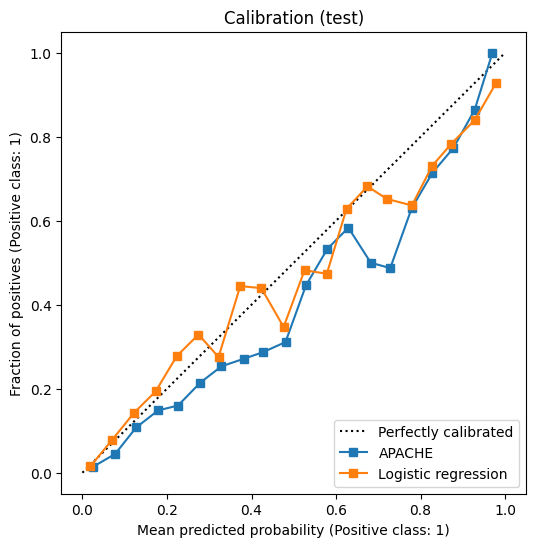

In [66]:
# calibration of logistic regression on test data
# compared to APACHE calibration
y_lr_test = lr.predict_proba(X_test)[:,1]
fig, ax = plt.subplots(figsize=(6, 6))
lr_calibration = CalibrationDisplay.from_predictions(
    y_test[y_apache_test >= 0], 
    y_apache_test[y_apache_test >= 0],
    n_bins=20,
    name="APACHE",
    ax=ax
).plot
lr_calibration = CalibrationDisplay.from_predictions(
    y_test, 
    y_lr_test,
    n_bins=20,
    name="Logistic regression",
    ax=ax
).plot
plt.title("Calibration (test)")
plt.show()

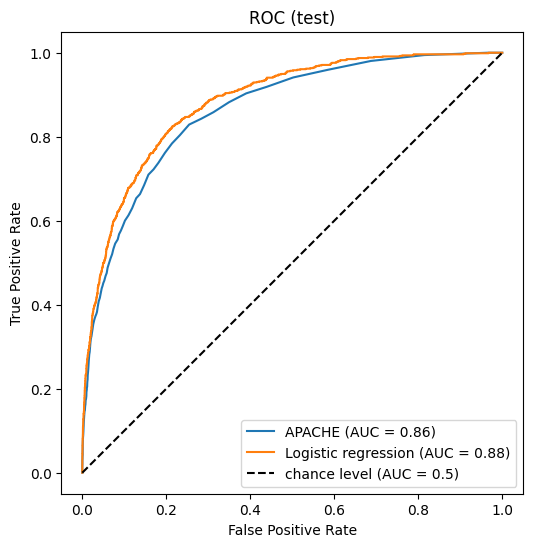

In [67]:
from sklearn.metrics import RocCurveDisplay, auc

fig, ax = plt.subplots(figsize=(6, 6))
roc_curve = RocCurveDisplay.from_predictions(
    y_test[y_apache_test >= 0], 
    y_apache_test[y_apache_test >= 0], 
    name=f"APACHE",
    ax=ax)
roc_curve = RocCurveDisplay.from_predictions(
    y_test, 
    y_lr_test,
    name=f"Logistic regression",
    ax=ax)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (test)")
plt.legend()
plt.show()

GWBoost:

In [68]:
#pre-processing:

test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("imputer", SimpleImputer(strategy="mean")),
                                  ("scaler", StandardScaler())
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"))])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])
# pipeline
prep_pipeline.fit(X_train, y_train)
# display(prep_pipeline) # display preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

Time: 2.06s
Train set: 73370 rows, 184 columns
Validation set: 9171 rows, 184 columns
Test set: 9172 rows, 184 columns


In [115]:
#Source: 
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://www.datacamp.com/tutorial/xgboost-in-python
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.005,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=9.2,
        seed=27
)

# train the model
xgb_model.fit(X_train, y_train)

# make predictions on the validation set
y_val_pred = xgb_model.predict(X_test)

y_val_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# calculate evaluation metrics on the validation set
val_acc = accuracy_score(y_test, y_val_pred)
val_auc = roc_auc_score(y_test, y_val_pred_proba)
val_precision = precision_score(y_test, y_val_pred)
val_recall = recall_score(y_test, y_val_pred)

print(y_val)
print(y_val_pred)

print(f"By using default parameters, accuracy score: {val_acc}")
print(f"By using default parameters, roc_auc_score: {val_auc}")
print(f"By using default parameters, precision score: {val_precision}")
print(f"By using default parameters, recall score: {val_recall}")





70808    0
85078    0
62074    0
90507    1
53078    0
        ..
78582    0
24577    0
84277    0
72528    1
64727    0
Name: hospital_death, Length: 9171, dtype: int64
[0 0 0 ... 0 0 1]
By using default parameters, accuracy score: 0.840165721761884
By using default parameters, roc_auc_score: 0.8951651672534243
By using default parameters, precision score: 0.32076473712161446
By using default parameters, recall score: 0.7635903919089759


In [ ]:
#Real tunning:
from sklearn.model_selection import RandomizedSearchCV


#param_grid = {
#    'learning_rate': [0.01, 0.05, 0.1, 0.2],
#    'n_estimators': [50, 100, 200, 300],
#    'max_depth': [3, 4, 5, 7],
#    'min_child_weight': [1, 3, 5, 7],
#    'gamma': [0, 0.1, 0.2, 0.3],
#    'subsample': [0.6, 0.8, 1.0],
#    'colsample_bytree': [0.6, 0.8, 1.0],
#    'reg_alpha': [0, 0.1, 0.2, 0.3]
#}

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.2]
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', nthread=4, seed=27)
i = 0
while True:
    i += 1
    random_search = RandomizedSearchCV(
            xgb_model,
            param_grid,
            scoring='roc_auc',
            n_jobs=-1,
            cv=5,
            verbose=2,
            n_iter=50,  
            random_state = None  
        )
    random_search.fit(X_train, y_train)

    start_time = time.time()

    random_search.fit(X_train, y_train)
    current_score = random_search.best_score_
    current_params = random_search.best_params_
    best_score = 0
    print(f"Best parameters found in iteration {i}: ", current_params)
    if current_score > best_score:
        best_score = current_score
        best_params = current_params
    print("Time elapsed for iteration {}: ".format(i), time.time() - start_time)

    print("Overall best parameters found: ", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [116]:
#after tunning

xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=300,
        max_depth=3,
        min_child_weight=3,
        gamma=0.2,
        subsample=0.8,
        colsample_bytree=1.0,
        reg_alpha=0.2,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=9.2,
        seed=27
)

# train the model
xgb_model.fit(X_train, y_train)

# make predictions on the validation set
y_val_pred = xgb_model.predict(X_val)
y_xgb_pred_proba_val = xgb_model.predict_proba(X_val)[:, 1]

# calculate evaluation metrics on the validation set
val_acc = accuracy_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_xgb_pred_proba_val)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

print(y_val)
print(y_val_pred)

print(f"By using tunned parameters, accuracy score: {val_acc}")
print(f"By using tunned parameters, roc_auc_score: {val_auc}")
print(f"By using tunned parameters, precision score: {val_precision}")
print(f"By using tunned parameters, recall score: {val_recall}")




70808    0
85078    0
62074    0
90507    1
53078    0
        ..
78582    0
24577    0
84277    0
72528    1
64727    0
Name: hospital_death, Length: 9171, dtype: int64
[0 1 0 ... 0 0 0]
By using tunned parameters, accuracy score: 0.8466906553265728
By using tunned parameters, roc_auc_score: 0.899244731118278
By using tunned parameters, precision score: 0.33204845814977973
By using tunned parameters, recall score: 0.757537688442211


XGBoost source for tunning parameters: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/